In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import re
import seaborn as sns
!pip install graphviz
!pip install -U imbalanced-learn

import graphviz
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn import preprocessing
from sklearn.feature_selection import VarianceThreshold,RFECV
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV, RepeatedStratifiedKFold,StratifiedKFold
from sklearn.tree import export_graphviz
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
import six
import sys
sys.modules['sklearn.externals.six'] = six
from sklearn.externals.six import StringIO
startup_df = pd.read_csv("modelling_df.csv", delimiter=',', header = 0, encoding = "ISO-8859-1",skipinitialspace=True)

startup_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3267 entries, 0 to 3266
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   market                3267 non-null   object 
 1   funding_rounds        3267 non-null   float64
 2   founded_month         3267 non-null   float64
 3   founded_year          3267 non-null   float64
 4   seed                  3267 non-null   float64
 5   venture               3267 non-null   float64
 6   equity_crowdfunding   3267 non-null   float64
 7   undisclosed           3267 non-null   float64
 8   convertible_note      3267 non-null   float64
 9   debt_financing        3267 non-null   float64
 10  angel                 3267 non-null   float64
 11  grant                 3267 non-null   float64
 12  private_equity        3267 non-null   float64
 13  secondary_market      3267 non-null   float64
 14  product_crowdfunding  3267 non-null   float64
 15  round_A              


# RANDOM FOREST


In [18]:
## Copy the DataFrame for modeling
modelling_df = startup_df.copy()

# One-hot encode categorical variables and prepare features (X) and target variable (y)
X = pd.get_dummies(modelling_df.drop(['status_binary'], axis=1))
y = modelling_df['status_binary']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=10)

# Test different numbers of estimators for RandomForestClassifier
n_estimators_list = list(range(10, 201, 10))

# Iterate over different numbers of estimators
for n in n_estimators_list:
    # Create a RandomForestClassifier with n_estimators trees
    model = RandomForestClassifier(n_estimators=n)

    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Print the training and testing scores for the current model
    print('{} Estimators - Train Score: {:.3f} | Test Score: {:.3f}'.format(n, model.score(X_train, y_train), model.score(X_test, y_test)))



10 Estimators - Train Score: 0.974 | Test Score: 0.696
20 Estimators - Train Score: 0.990 | Test Score: 0.676
30 Estimators - Train Score: 0.993 | Test Score: 0.700
40 Estimators - Train Score: 0.995 | Test Score: 0.689
50 Estimators - Train Score: 0.995 | Test Score: 0.695
60 Estimators - Train Score: 0.995 | Test Score: 0.709
70 Estimators - Train Score: 0.995 | Test Score: 0.703
80 Estimators - Train Score: 0.995 | Test Score: 0.696
90 Estimators - Train Score: 0.995 | Test Score: 0.707
100 Estimators - Train Score: 0.995 | Test Score: 0.690
110 Estimators - Train Score: 0.995 | Test Score: 0.698
120 Estimators - Train Score: 0.995 | Test Score: 0.700
130 Estimators - Train Score: 0.995 | Test Score: 0.709
140 Estimators - Train Score: 0.995 | Test Score: 0.703
150 Estimators - Train Score: 0.995 | Test Score: 0.711
160 Estimators - Train Score: 0.995 | Test Score: 0.698
170 Estimators - Train Score: 0.995 | Test Score: 0.700
180 Estimators - Train Score: 0.995 | Test Score: 0.702
1

AUC: 0.751


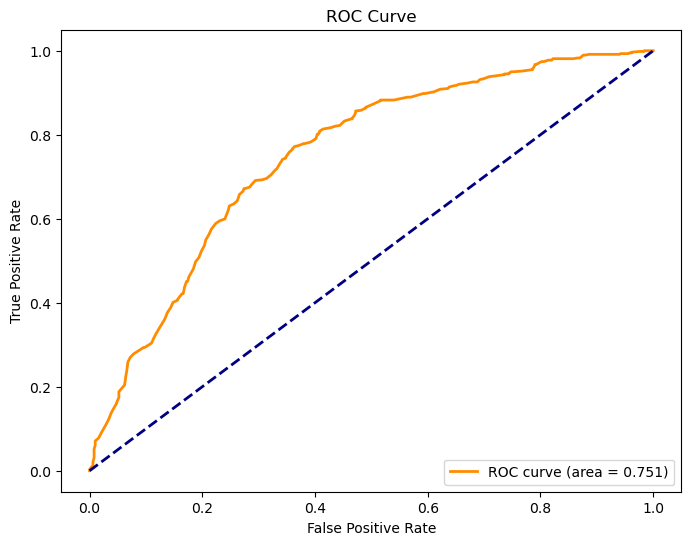

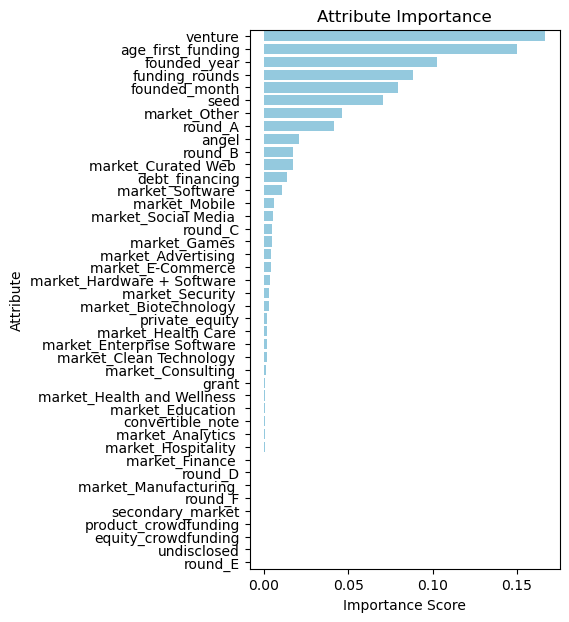

Cross-Validation Results:
   Fold  AUC Score
0     1   0.710282
1     2   0.790598
2     3   0.794243
3     4   0.741003
4     5   0.779335
5     6   0.758663
6     7   0.741128
7     8   0.773184
8     9   0.746028
9    10   0.738590

Mean AUC: 0.757
Standard Deviation: 0.025


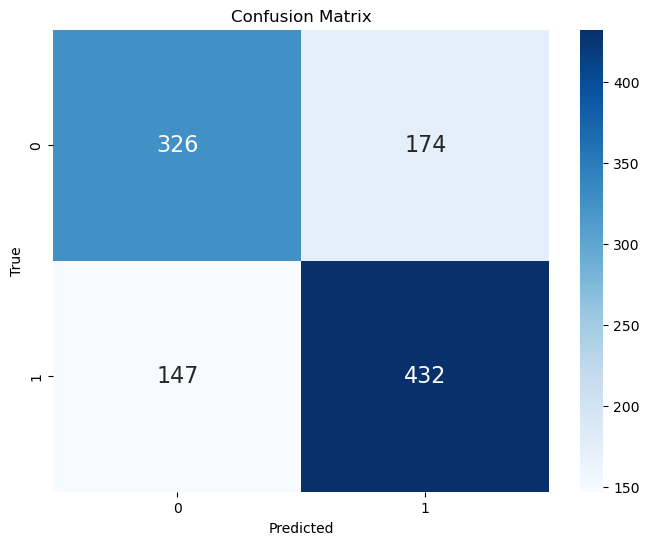


Classification Report:
               precision    recall  f1-score   support

           0      0.689     0.652     0.670       500
           1      0.713     0.746     0.729       579

    accuracy                          0.703      1079
   macro avg      0.701     0.699     0.700      1079
weighted avg      0.702     0.703     0.702      1079



In [20]:

best_model = RandomForestClassifier(n_estimators=150, random_state=10)  
# Fit the best model on the entire training dataset
best_model.fit(X_train, y_train)

# Make predictions on the test set using the best model
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Calculate AUC
auc = roc_auc_score(y_test, y_pred_proba)
print(f'AUC: {auc:.3f}')

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.3f})'.format(auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Feature importance using best model
permutation_result = permutation_importance(best_model, X_train, y_train, n_repeats=10, random_state=0)
feature_importances = pd.Series(permutation_result.importances_mean, index=X_train.columns.values).sort_values(ascending=False)

# Create a horizontal bar plot using seaborn
sorted_fimp = feature_importances.sort_values(ascending=False)
sns.barplot(x=sorted_fimp.values, y=sorted_fimp.index, color='skyblue')
plt.rcParams['figure.figsize'] = 4, 7
plt.xlabel('Importance Score')
plt.ylabel('Attribute')
plt.title('Attribute Importance')
plt.savefig('attribute_importance_plot.png', bbox_inches='tight')
plt.show()

# Cross-validation using best model
cv_scores = cross_val_score(best_model, X_train, y_train, cv=10, scoring='roc_auc')
cv_results = pd.DataFrame({
    'Fold': range(1, len(cv_scores) + 1),
    'AUC Score': cv_scores
})

# Print the table with mean and standard deviation
print("Cross-Validation Results:")
print(cv_results)
print("\nMean AUC: {:.3f}".format(cv_scores.mean()))
print("Standard Deviation: {:.3f}".format(cv_scores.std()))

# Confusion Matrix using best model
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", annot_kws={"size": 16})
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification Report using best model
classification_report_result = classification_report(y_test, y_pred, digits=3)
print("\nClassification Report:\n", classification_report_result)


# WITH SMOTE

10 Estimators - Train Score: 0.979 | Test Score: 0.682
20 Estimators - Train Score: 0.990 | Test Score: 0.671
30 Estimators - Train Score: 0.994 | Test Score: 0.692
40 Estimators - Train Score: 0.996 | Test Score: 0.703
50 Estimators - Train Score: 0.996 | Test Score: 0.698
60 Estimators - Train Score: 0.995 | Test Score: 0.690
70 Estimators - Train Score: 0.995 | Test Score: 0.692
80 Estimators - Train Score: 0.996 | Test Score: 0.700
90 Estimators - Train Score: 0.996 | Test Score: 0.691
100 Estimators - Train Score: 0.996 | Test Score: 0.699
110 Estimators - Train Score: 0.996 | Test Score: 0.700
120 Estimators - Train Score: 0.996 | Test Score: 0.700
130 Estimators - Train Score: 0.996 | Test Score: 0.698
140 Estimators - Train Score: 0.996 | Test Score: 0.700
150 Estimators - Train Score: 0.996 | Test Score: 0.699
160 Estimators - Train Score: 0.996 | Test Score: 0.696
170 Estimators - Train Score: 0.996 | Test Score: 0.694
180 Estimators - Train Score: 0.996 | Test Score: 0.704
1

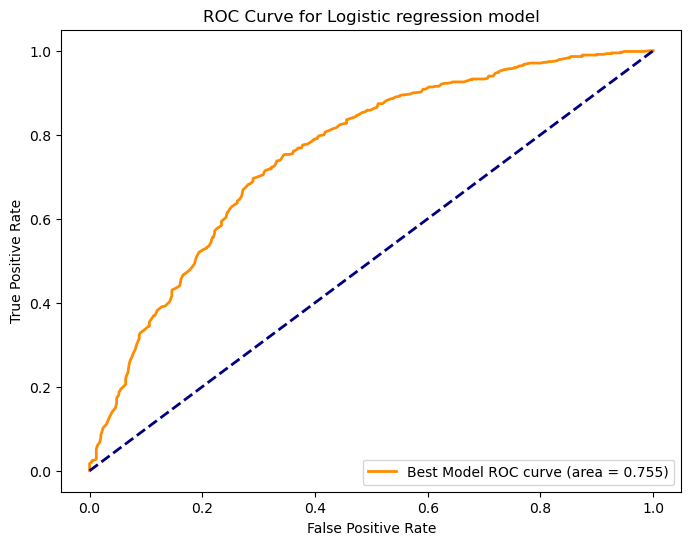

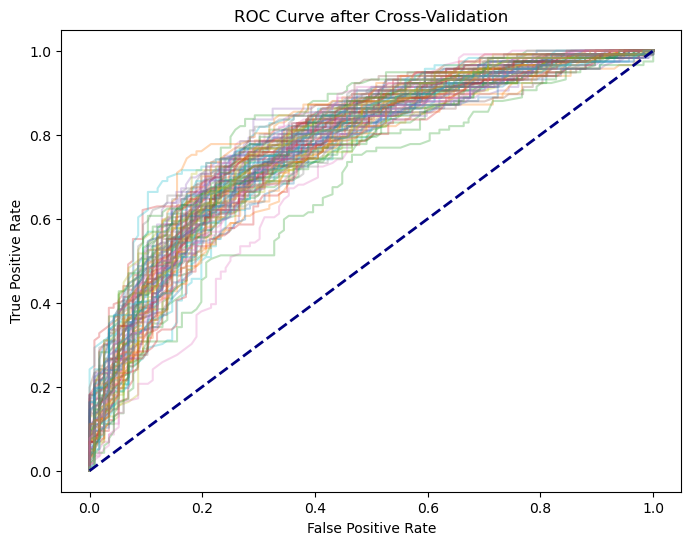

Cross-Validation Results for LOGISTIC REGRESSION Model:
   Fold  AUC Score
0     1   0.710875
1     2   0.809203
2     3   0.771552
3     4   0.729701
4     5   0.806108
5     6   0.775125
6     7   0.727965
7     8   0.781287
8     9   0.718378
9    10   0.876040

Mean AUC: 0.771
Standard Deviation: 0.049


In [21]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE

# Copy the DataFrame for modeling
modelling_df = startup_df.copy()

# One-hot encode categorical variables and prepare features (X) and target variable (y)
X = pd.get_dummies(modelling_df.drop(['status_binary'], axis=1))
y = modelling_df['status_binary']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=10)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Test different numbers of estimators for RandomForestClassifier
n_estimators_list = list(range(10, 201, 10))

# Track the best model and its score
best_model = None
best_score = 0.0

# Iterate over different numbers of estimators
for n in n_estimators_list:
    # Create a RandomForestClassifier with n_estimators trees
    model = RandomForestClassifier(n_estimators=n)

    # Fit the model on the resampled data
    model.fit(X_resampled, y_resampled)

    # Evaluate the model on the test data
    test_score = model.score(X_test, y_test)

    # Print the training and testing scores for the current model
    print('{} Estimators - Train Score: {:.3f} | Test Score: {:.3f}'.format(n, model.score(X_resampled, y_resampled), test_score))

    # Update the best model if the current model performs better
    if test_score > best_score:
        best_score = test_score
        best_model = model

# Make predictions on the test set and calculate ROC curve and AUC for the best model
y_pred_proba_best = best_model.predict_proba(X_test)[:, 1]
auc_best = roc_auc_score(y_test, y_pred_proba_best)

# Plot ROC curve for the best model
fpr_best, tpr_best, _ = roc_curve(y_test, y_pred_proba_best)
plt.figure(figsize=(8, 6))
plt.plot(fpr_best, tpr_best, color='darkorange', lw=2, label='Best Model ROC curve (area = {:.3f})'.format(auc_best))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic regression model')
plt.legend(loc='lower right')
plt.show()

# Cross-validation on the resampled data using the best model
cv_scores_best = cross_val_score(best_model, X_resampled, y_resampled, cv=10, scoring='roc_auc')

# Plot ROC curve after cross-validation
plt.figure(figsize=(8, 6))
for train_index, test_index in cross_val.split(X_resampled, y_resampled):
    model_cv = RandomForestClassifier(n_estimators=best_model.n_estimators)
    model_cv.fit(X_resampled.iloc[train_index], y_resampled.iloc[train_index])
    y_pred_proba_cv = model_cv.predict_proba(X_resampled.iloc[test_index])[:, 1]
    fpr_cv, tpr_cv, _ = roc_curve(y_resampled.iloc[test_index], y_pred_proba_cv)
    plt.plot(fpr_cv, tpr_cv, alpha=0.3)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve after Cross-Validation')
plt.show()

# Display the cross-validation results
cv_results_best = pd.DataFrame({
    'Fold': range(1, len(cv_scores_best) + 1),
    'AUC Score': cv_scores_best
})

print("Cross-Validation Results for LOGISTIC REGRESSION Model:")
print(cv_results_best)
print("\nMean AUC: {:.3f}".format(cv_scores_best.mean()))
print("Standard Deviation: {:.3f}".format(cv_scores_best.std()))


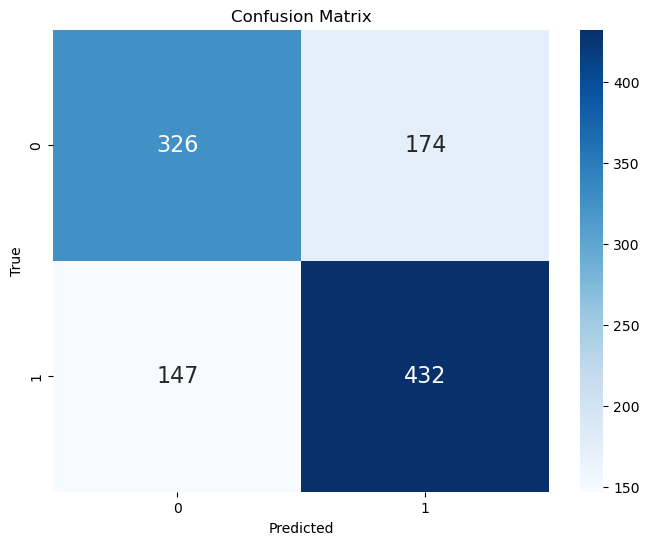


Classification Report:
               precision    recall  f1-score   support

           0      0.689     0.652     0.670       500
           1      0.713     0.746     0.729       579

    accuracy                          0.703      1079
   macro avg      0.701     0.699     0.700      1079
weighted avg      0.702     0.703     0.702      1079



In [22]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", annot_kws={"size": 16})
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification Report
classification_report_result = classification_report(y_test, y_pred, digits=3)
print("\nClassification Report:\n", classification_report_result)


In [13]:
# Step 4: Make a single prediction on a random sample from the test set
pred = X_test.sample(n=1)
outcome = model.predict(pred)
print('Predicted Class: {}'.format(outcome[0]))

# Step 5: Display the prediction and associated confidence
if outcome == 1:
    confidence = np.mean(model.predict_proba(pred)[:, 1])
    print('This startup is predicted to be successful with {:.1f}% confidence.'.format(confidence * 100))
    display(pred)
elif outcome == 0:
    confidence = np.mean(1 - model.predict_proba(pred)[:, 1])
    print('This startup is predicted NOT to be successful with {:.1f}% confidence.'.format(confidence * 100))
    display(pred)


Predicted Class: 0
